## Set up

In [0]:
# connect to google drive
import os
import numpy as np

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# change root directory such that models are saved in google drive during training
root_dir = "/content/gdrive/My Drive/DeepFLY"
os.chdir(root_dir)
# print the contents
!ls

all_attractions.pkl	    poi_database.json
all_reviews.pkl		    poi_features_use.npy
apify_data		    scrape_data_with_apify.ipynb
EDA.ipynb		    scrape_triposo_refactored.ipynb
Feature_extraction.ipynb    scripts
features		    TA_scrape.ipynb
image_data		    text_data
LP_Scrape.ipynb		    tfidf_features.npy
Modelling.ipynb		    triposo_data
Modelling_refactored.ipynb  Triposo_Scrape.ipynb
notebook2script.py


### Imports

In [0]:
# export
import math
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import sleep
import sys
import re
import shutil
import json
from tqdm import tqdm_notebook
import tqdm
import operator
from collections import OrderedDict
import pickle
import itertools
import gc
import re
import logging
import urllib.request
import matplotlib.image as mpimg
#from tqdm import tqdm_notebook

import spacy
nlp = spacy.load('en_core_web_sm')

## pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# export
# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS # need to install
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, decomposition
from sklearn.metrics.pairwise import linear_kernel

In [0]:
# export
# insert the path for utility custom functions
import sys
sys.path.insert(0, os.path.join(root_dir, 'scripts'))
# custom python functions and classes
from nb_scrape_triposo import create_df, poi_counts
from nb_imgdload import dloadImage

### Load Triposo Data

In [0]:
## Load triposo data
with open('poi_database.json','r') as f:
  poi_dataset = json.load(f)
## Convert to dataframe
poi_df = create_df(poi_dataset)

In [0]:
## Remove \n from start and end
def remove_new_line(x):
  try:
    return x[1:-1]
  except:
    pass

## Length of info
def word_counter(x):
  try:
    return len(x.split(' '))
  except:
    return 0

In [0]:
# basic cleaning
poi_df['info_clean'] = poi_df['info'].apply(lambda x: remove_new_line(x))  
poi_df['word_count'] = poi_df['info'].apply(lambda x: word_counter(x))
poi_df = poi_df.drop(columns = ['info'], axis = 1)

# Drop POI with less than 6 in the word count
poi_df = poi_df[poi_df.word_count >= 6]
poi_df = poi_df.reset_index(drop=True)

### Features

#### TF-iDF Based features

In [0]:
## Use TF-iDF for extracting email features
tf_op = TfidfVectorizer(analyzer = 'word', max_df = 0.95, min_df = 5, max_features = 5000)
tfidf_matrix = tf_op.fit_transform(poi_df['info_clean'])
tfidf_matrix.shape

(230625, 5000)

#### Google Universal  Sentence Encoder Features

In [0]:
## Load features (ref: Feature_extraction.ipynb)
poi_features_use = np.load('poi_features_use.npy') # load

### Group POIs based on their parent location

In [0]:
### All travel destination groups 
tr_dest =  poi_df.groupby('location')
print('Number of destinations in the database: {}'.format(len(tr_dest)))

Number of destinations in the database: 36151


### Sample POI for showing to users

In [0]:
# export
## Select diverse POis
def sample_input_df(poi_df, n=5):
  """
  Select possible images to be shown to users by
  sampling 'n' POI for each POI type
  
  @params
  poi_df: DataFrame of all POIs
  n: int -> number of POIs to be selected for each category
  
  @returns
  DataFrame -> contaings examples that will be shown to users
  
  """
  # filter POIs with images 
  poi_df['has_image'] =  poi_df['image'].apply(lambda x: True if x else False)
  input_valid_examples = poi_df[poi_df['has_image']]
  
  ## Group POIs according to poi_type
  poi_type_groups = input_valid_examples.groupby('poi_type')

  ## Sample n images from each POI type
  sample_list = []
  for poi_gr, df_gr in poi_type_groups:

      num_sample = min(n, len(df_gr))
      selected_ex = df_gr.sample(num_sample)
      sample_list.append(selected_ex)
  ## concatenate to make the dataframe
  input_df = pd.concat(sample_list)
  return input_df
  

In [0]:
### Sample 5 POI name and description
sample_input_df(poi_df).sample(5)

,country,image,location,name,poi_id,poi_type,url,info_clean,word_count,has_image
119425,Sweden,pic.triposo.com/ios/cas/medium/9cec/9cec5d6021...,Vadstena,Östergötland Runic Inscription 179,2,stela,https://www.triposo.com/poi/C396stergC3B6tland...,The runestone known as Östergötland Rune Inscr...,212,True
214831,New_Jersey,pic.triposo.com/ios/cas/medium/be0b/be0b1e7f2a...,Pennington,Stony Brook Millstone Watershed Arboretum,1,botanical garden,https://www.triposo.com/poi/T__0c8dc23631ea,The Stony Brook Millstone Watershed Arboretum ...,94,True
195401,Illinois,pic.triposo.com/ios/cas/medium/1758/17584f10b1...,Glen Ellyn,College of DuPage,5,university,https://www.triposo.com/poi/W__129384326,College of DuPage is a two-year community coll...,148,True
69775,Germany,pic.triposo.com/ios/cas/medium/d14a/d14a50dbcc...,Weißenburg,Rekonstruktion der Porta decumana,14,city gate,https://www.triposo.com/poi/T__19d2dbe50e40,Rekonstruktion der Porta decumana is a city ga...,13,True
195600,Illinois,pic.triposo.com/ios/cas/medium/f9b5/f9b58a031c...,Joliet,Old Joliet Prison,14,prison,https://www.triposo.com/poi/T__c338b0179bde,Old Joliet Prison is a prison in Joliet.,8,True


### Scoring system

In [0]:
## Scoring method for a travel destination
def soft_sum(x):
  """ 
  Aggregation method to compute an overall
  score for a travel destination by taking weighted 
  sum of underlying POI scores
  
  @params
  x: List --> POI scores for a travel destination sorted in descending order
  
  @returns
  float -> overall score of a travel destination
  """
  scr = 0
  w = 0
  for i, val in enumerate(x):
    scr += val*np.exp(-0.6*i)
    w += np.exp(-0.6*i)
    #print('Current weight = {}, score = {}'.format(np.exp(-0.6*i),val))
  #print('Total sum of weights = {}'.format(w))
  return scr/w

##
def get_location_scores(sim_scores, tr_dest):
  """
  Computes overall scores of all travel destinations by using soft_sum
  
  @params
  sim_scores: ndarray -> similarity scores of POI wrt a rated POI
  tr_dest: pandas groupby object -> contains information regarding travel destinations
  """
  
  scores_dict = {}

  for dest, df_dest in tr_dest:
      
      scores = sorted(sim_scores[df_dest.index],reverse=True)
      dest_score = soft_sum(scores)
      scores_dict[dest] = dest_score
  
  scores_df = pd.Series(scores_dict)
  return scores_df
##

### Reading user inputs

In [0]:
def get_user_input(input_df, num_input = 5):
  """ 
  Reads in user ratings for num_input POIs
  
  @params
  input_df: DataFrame containing diverse range of POIs to be shown to the user
  num_input: number of POIs to be shown to the user 
  
  @returns 
  tuple (rated_indices, ratings) where
  rated_indices: list of indices of the rated POIs
  ratings: corresponding list of user ratings
  """
  ## Select num_input POI randomly from input_df
  poi_rated = input_df.sample(num_input)
  df_focus = poi_rated[['name','info_clean','poi_type', 'location','image', 'country']]
  ## Get user ratings
  rated_indices = []
  ratings = []
  for idx, row in df_focus.iterrows():
    
    ## Show POI information to user
    print("POI: {}, Location: {} in {}, POI type: {}".format(row['name'], row['location'], row['country'], row['poi_type']))

    ### Show text description
    print('Description: ')
    desc = row['info_clean'].split(' ')[0:15]
    desc.append('...')
    print(' '.join(desc))
    ### Show image of the POI
    L = []
    L.append(row['image'])
    dloadImage(L, row['location'],  num_img = 1, show = True)
    
    ## Read in user rating
    rate_poi = input('Your rating:')
    
    ## store indices and ratings
    rated_indices.append(idx)
    ratings.append(rate_poi)
    print('=='*5)
    
  return (rated_indices, ratings)

POI: Regional District of Fraser Fort George, Location: Prince George in Canada, POI type: city hall
Description: 
The Regional District of Fraser-Fort George provides services to foster economic, social and environmental well ...


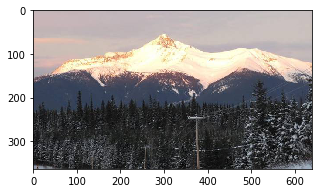

Your rating:4
POI: Second Street Players, Location: Milford in Delaware, POI type: theatre
Description: 
Riverfront Theatre is located at 2 South Walnut Street on the south bank of the ...


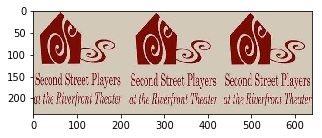

Your rating:2
POI: Affensteine, Location: Saxon Switzerland National Park in Germany, POI type: rock
Description: 
The Affensteine are a long chain of deeply fissured rocks in the Elbe Sandstone Mountains ...


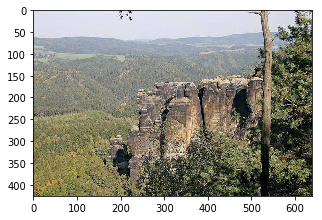

Your rating:5
POI: Allegheny Observatory, Location: Pittsburgh in Pennsylvania, POI type: planetarium
Description: 
The Allegheny Observatory is an American astronomical research institution, a part of the Department of ...


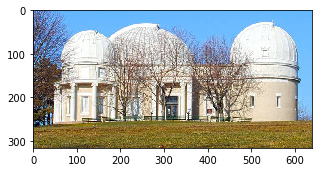

Your rating:2
POI: Rolnick Observatory, Location: Westport in Connecticut, POI type: planetarium
Description: 
The Westport Observatory is an astronomical observatory in Westport, Connecticut, operated by the Westport Astronomical ...


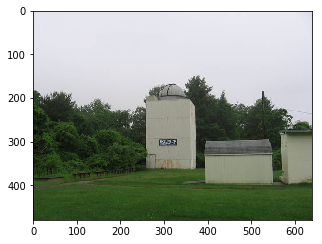

Your rating:4


In [0]:
## Test user inputs
input_df = sample_input_df(poi_df)
indices, ratings = get_user_input(input_df)

In [0]:
ratings

['4', '2', '5', '2', '4']

In [0]:
indices

[28534, 230034, 66213, 177653, 229116]

#### TF-iDF based recommender system

In [0]:
### Sample 5 POI name and description

def rec_sys_tf_idf(indices, ratings, tfidf_matrix, tr_dest):
  """
  Content based recommender system based on TF-iDF features
  
  @params
  indices: List -> indices of POIs rated by user
  ratings: List -> Corresponding user ratings
  tfidf_matrix: ndarray/matrix -> Features of all POIs
  tr_dest: pandas groupby object containing travel destinations
  
  @returns
  net_scores: pandas Series -> scores of all travel destinations
  """
  
  scores = [] # placeholder for similarity scores for each rated POI
  for idx in indices:
    ## Get TF-iDF feature of current POI
    tf_cur = tfidf_matrix[idx]
    ## Compute similarity with other POIs in the database
    sim_scores =  linear_kernel(tfidf_matrix, tf_cur).squeeze()
    ## Combine POI similarity scores -> overall score for travel destinations
    tr_scores = get_location_scores(sim_scores, tr_dest)
    ## Store overall similarity scores 
    scores.append(tr_scores)
  
  ## Combine scores as per user ratings
  ratings = np.array(ratings, dtype= float)
  ## unbiased ratings
  R_unbiased = ratings - np.mean(ratings)
  ## Compute dot product net score
  trScore = pd.concat(scores, axis=1)
  trScore['agg_tf'] = trScore.apply(lambda x: np.dot(x,R_unbiased), axis=1)
  #
  net_scores = trScore['agg_tf']
  #net_scores = np.array(trScore['agg'].values)
  return  net_scores


In [0]:
S_tf = rec_sys_tf_idf(indices, ratings, tfidf_matrix, tr_dest)

In [0]:
S_tf.head()

's-Gravendeel       0.016808
's-Hertogenbosch   -0.062468
100 Mile House      0.075887
A Coruña            0.086564
A Estrada          -0.052082
Name: agg_tf, dtype: float64

#### Universal Sentence Encoder based Recommender System

In [0]:
def rec_sys_use(indices, ratings, poi_features_use, tr_dest):
  
  """
  Content based recommender system based on Universal
  Sentence Encoder features
  
  @params
  indices: List -> indices of POIs rated by user
  ratings: List -> Corresponding user ratings
  tfidf_matrix: ndarray/matrix -> USE features of all POIs
  tr_dest: pandas groupby object containing travel destinations
  
  @returns
  net_scores: pandas Series -> scores of all travel destinations
  """
  
  scores = [] # placeholder for similarity scores for each rated POI
  for idx in indices:
    ## Get TF-iDF feature of current POI
    use_cur = poi_features_use[idx].reshape(1,-1)
    ## Compute similarity with other POIs in the database
    sim_scores =  linear_kernel(poi_features_use, use_cur).squeeze()
    ## Combine POI similarity scores -> overall score for travel destinations
    tr_scores = get_location_scores(sim_scores, tr_dest)
    ## Store overall similarity scores 
    scores.append(tr_scores)
  
  ## Combine scores as per user ratings
  ratings = np.array(ratings, dtype= float)
  ## unbiased ratings
  R_unbiased = ratings - np.mean(ratings)
  ## Compute dot product net score
  useScore = pd.concat(scores, axis=1)
  useScore['agg_use'] = useScore.apply(lambda x: np.dot(x,R_unbiased), axis=1)
  #
  net_scores = useScore['agg_use']
  #net_scores = np.array(trScore['agg'].values)
  return  net_scores

In [0]:
S_use = rec_sys_use(indices, ratings, poi_features_use, tr_dest)

In [0]:
S_use.head()

's-Gravendeel       0.030250
's-Hertogenbosch   -0.257474
100 Mile House     -0.074165
A Coruña           -0.208699
A Estrada          -0.374181
Name: agg_use, dtype: float64

#### Utility function

In [0]:
def rec_top_N(df, tr_dest, N=10, show=False):
  
  """
  Shows top N destination to user
  
  @params
  df: DataFrame -> sorted according to height similarity scores
  tr_dest: pandas groupby object -> contains information regarding travel destinations
  N: int -> how many places to recommend to user
  show: Boolean -> whether to show images of the recommend places
  
  @returns
  None
  """
  places = list(df.index) # name of the places

  for i, place in enumerate(places):
    cur_place = tr_dest.get_group(place)
    pic_urls = list(cur_place.image)
    print('Rec #{}: {} in {} ({})'.format(i+1,place, cur_place.iloc[0]['country'], cur_place.iloc[0]['poi_type']))
    if show:
      dloadImage(pic_urls, place, num_img=2, show=True)

In [0]:
def show_sys_rec(sys_rec, show_breakdown = False, show_images= False):
  
  """
  Shows recommendation to users
  
  @params
  sys_rec: tuple -> output from deepFLY function
  show_breakdown: Boolean -> whether to show recommendations from all the methods
  show_images: to show images of recommended places or not
  """
  N = len(sys_rec[0])
  if show_breakdown:
    print('\nTop {} DeepFLY recommendations: \n'.format(N))
    rec_top_N(sys_rec[0], tr_dest)
    
    print('\nTop {} TF recommendations: \n'.format(N))
    rec_top_N(sys_rec[1], tr_dest)
    print('\n')

    print('\nTop {} USE recommendations: \n'.format(N))
    rec_top_N(sys_rec[2], tr_dest)
    print('\n')
  
  if show_images:
    print('\nTop {} recommendations with images: \n'.format(N))
    rec_top_N(sys_rec[0], tr_dest, show=show_images)
  

### deepFLY: combined recommender system

In [0]:
def deepFLY(poi_df, tfidf_matrix, poi_features_use, tr_dest, num_input=5, N=10):
        
  """
  Recommends tourist destinations to the users based on their ratings
  
  @params
  poi_df: DataFrame -> all POIs 
  tfidf_matrix: ndarray/matrix -> TF-iDF features of all POIs
  poi_features_use: ndarray -> USE features of all POIs
  tr_dest: pandas groupby object -> contains information regarding travel destinations
  N: int -> how many places to recommend
  
  @retuens
  sys_rec: tuple -> places recommended based on blended, tf-idf, use methods
  """
  
  ## Get user inputs
  input_df = sample_input_df(poi_df)
  indices, ratings = get_user_input(input_df, num_input)
  print('=='*20)
  print('Processing ...')
  
  ##
  S_tf = rec_sys_tf_idf(indices, ratings, tfidf_matrix, tr_dest)
  S_use = rec_sys_use(indices, ratings, poi_features_use, tr_dest)
    
  ### Normalize scores
  S_tf = (S_tf/np.linalg.norm(S_tf))*math.sqrt(len(S_tf))
  S_use = (S_use/np.linalg.norm(S_use))*math.sqrt(len(S_use))
  all_S = pd.concat([S_tf, S_use], axis = 1)
  ### Blend scores weight = [0.4, 0.6]
  weights = [0.3, 0.7]
  all_S['blended'] = all_S.apply(lambda x: np.dot(weights,x), axis = 1)
  ## Sort scores and retain top N locations
  rec_tf = (all_S.sort_values(by =['agg_tf'], ascending = False)).head(N)
  rec_use = (all_S.sort_values(by =['agg_use'], ascending = False)).head(N)
  rec_blended = (all_S.sort_values(by =['blended'], ascending = False)).head(N)
  
  ## Recommendations
  sys_rec = (rec_blended, rec_tf, rec_use)
  print('Done!')
  print('=='*20)
  
  return sys_rec



### Run DeepFLY

POI: Beech Street Center, Location: Belmont in Massachusetts, POI type: street
Description: 
More than a senior center, Beech Street Center offers a wide range of activities, resources, ...


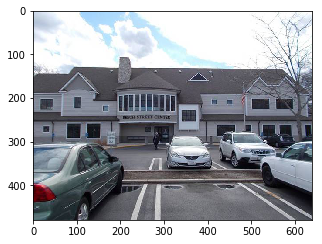

Your rating:1
POI: Meirinkan, Location: Hagi in Japan, POI type: school
Description: 
Meirinkan was a han school located in the Chōshū Domain of Japan. The school was ...


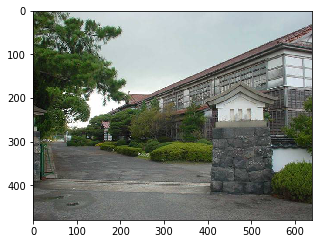

Your rating:1
POI: Weldon Historic District, Location: Weldon in North_Carolina, POI type: interesting neighbourhood
Description: 
Weldon Historic District is a national historic district located at Weldon, Halifax County, North Carolina. ...


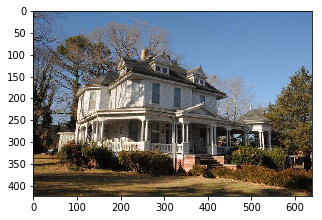

Your rating:2
POI: Blackpool Sands, Location: Dartmouth in United_Kingdom, POI type: beach
Description: 
Not to be confused with Blackpool Sands, Blackpool.Blackpool Sands is a beach in Dartmouth, Devon, ...


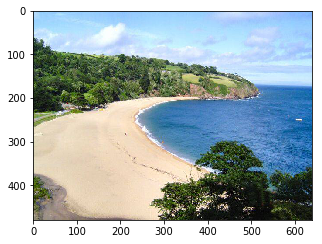

Your rating:5
POI: Grootrivier Pass, Location: Nature's Valley in South_Africa, POI type: mountain pass
Description: 
Grootrivier Pass, is situated in the Western Cape province of South Africa on the R102 ...


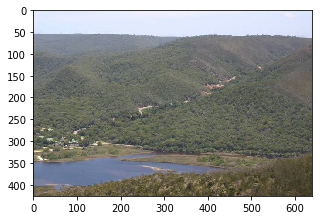

Your rating:5
POI: Tillegem Castle, Location: Bruges in Belgium, POI type: castle
Description: 
Tillegem Castle is a castle in Belgium.Since 1980, the castle and its park have been ...


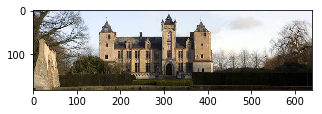

Your rating:4
POI: Mingo Falls, Location: Cherokee in North_Carolina, POI type: waterfall
Description: 
Mingo Falls is a 120ft high waterfall located in the Qualla Boundarya land trust of ...


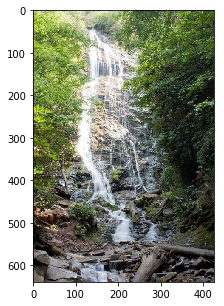

Your rating:3
POI: The Old Creamery Theatre Company, Location: Amana Colonies in Iowa, POI type: theatre
Description: 
The Old Creamery Theatre Company is a not-for-profit professional theatre founded in 1971 and located ...


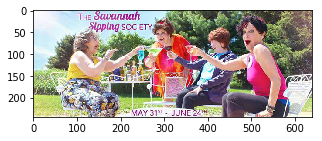

Your rating:2
POI: Shipquay Townhouse & Dayspa, Location: Derry in United_Kingdom, POI type: city wall
Description: 
True Beauty Starts From Within...At Shipquay Natural Health Clinic we are dedicated to enablingyou to ...


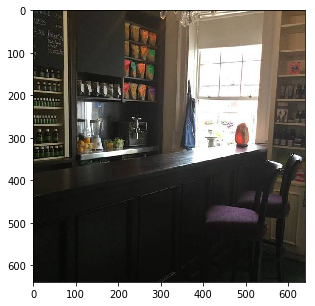

Your rating:1
POI: Star of Nanchang, Location: Nanchang in People27s_Republic_of_China, POI type: ferris wheel
Description: 
The Star of Nanchang is a 160m tall giant Ferris wheel located in the eastern ...


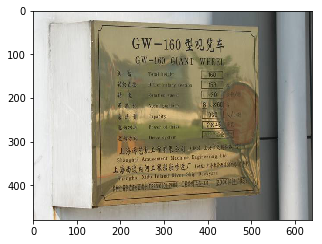

Your rating:2
POI: Hochstein, Location: Dahn in Germany, POI type: rock
Description: 
The Hochstein, near the little southwest Palatine town of Dahn in southwest Germany, is a ...


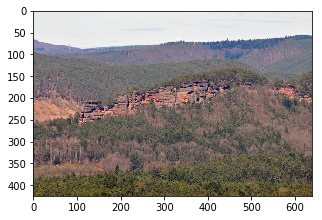

Your rating:4
POI: Catacombe dei Cappuccini, Location: Palermo in Italy, POI type: catacombs
Description: 
The Capuchin Catacombs of Palermo are burial catacombs in Palermo, Sicily, southern Italy. Today they ...


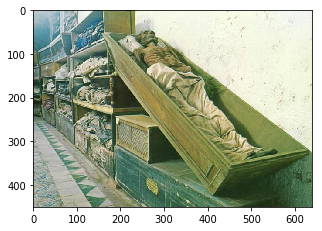

Your rating:2
Processing ...
Done!


In [0]:
## run
sys_rec = deepFLY(poi_df, tfidf_matrix, poi_features_use, tr_dest, num_input = 12)


Top 10 DeepFLY recommendations: 

Rec #1: Nature's Valley in South_Africa (sight)
Rec #2: Brecon Beacons in United_Kingdom (waterfall)
Rec #3: Skye in United_Kingdom (church)
Rec #4: Uplawmoor in United_Kingdom (lake)
Rec #5: Methoni in Greece (castle)
Rec #6: IJsseloog in Netherlands (lake)
Rec #7: Palatinate Forest-North Vosges Biosphere Reserve in Germany (castle)
Rec #8: Loch Lomond and The Trossachs National Park in United_Kingdom (mountain)
Rec #9: Loch Rannoch and Glen Lyon National Scenic Area in United_Kingdom (mountain)
Rec #10: Lulworth in United_Kingdom (arch)

Top 10 TF recommendations: 

Rec #1: Nature's Valley in South_Africa (sight)
Rec #2: Dartmouth in United_Kingdom (museum)
Rec #3: Dahn in Germany (castle)
Rec #4: Schlitz in Germany (castle)
Rec #5: Germersheim in Germany (bridge)
Rec #6: Bruges in Belgium (tower)
Rec #7: Riedenburg in Germany (museum)
Rec #8: Woburn Sands in United_Kingdom (memorial)
Rec #9: Rye in United_Kingdom (castle)
Rec #10: Paignton in Unite

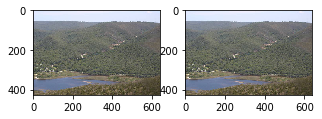

Rec #2: Brecon Beacons in United_Kingdom (waterfall)


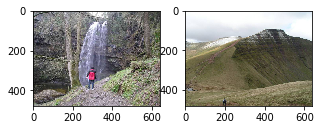

Rec #3: Skye in United_Kingdom (church)


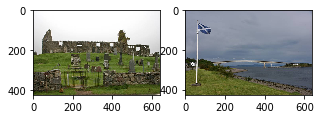

Rec #4: Uplawmoor in United_Kingdom (lake)


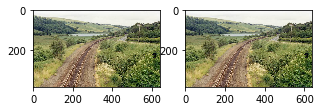

Rec #5: Methoni in Greece (castle)


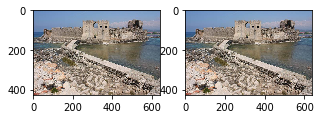

Rec #6: IJsseloog in Netherlands (lake)


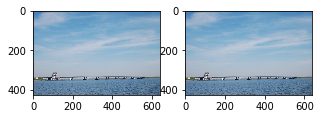

Rec #7: Palatinate Forest-North Vosges Biosphere Reserve in Germany (castle)


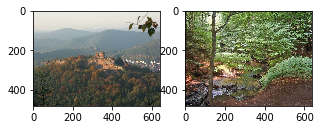

Rec #8: Loch Lomond and The Trossachs National Park in United_Kingdom (mountain)


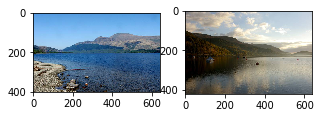

Rec #9: Loch Rannoch and Glen Lyon National Scenic Area in United_Kingdom (mountain)


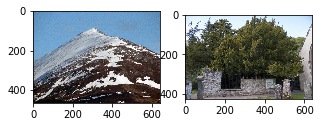

Rec #10: Lulworth in United_Kingdom (arch)


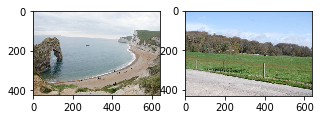

In [0]:
show_sys_rec(sys_rec, show_breakdown = True, show_images= True)

In [0]:
## 2nd Run
## run
sys_rec = deepFLY(poi_df, tfidf_matrix, poi_features_use, tr_dest, num_input = 15)
show_sys_rec(sys_rec, show_breakdown = True, show_images= True)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#### << ----- >> ####